In [1]:
from pathlib import Path
import requests

import rasterio as rio
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

from omnicloudmask import predict_from_array

In [2]:
required_res = 10

Go to https://www.maxar.com/open-data/ scroll to the bottom, select one of the captured events (from 2023 or late 2022) and click 'Learn more', on the new page select one of the scenes and click the corresponding 'QUAD KEY' button, from the new popup right click on the 'Multispectral Image' button and select copy url. Past that url below to download and run inference.


In [3]:
url = "https://maxar-opendata.s3.us-west-2.amazonaws.com/events/Emilia-Romagna-Italy-flooding-may23/ard/32/120000303231/2023-05-23/1050010033C95B00-ms.tif"
url = "https://maxar-opendata.s3.us-west-2.amazonaws.com/events/tonga-volcano21/ard/01/300222121030/2022-01-18/1040010071C26C00-ms.tif"
url = "https://maxar-opendata.s3.us-west-2.amazonaws.com/events/Kalehe-DRC-Flooding-5-8-23/ard/35/300000303201/2023-05-12/1040010084614200-ms.tif"
url = "https://maxar-opendata.s3.us-west-2.amazonaws.com/events/New-Zealand-Flooding23/ard/60/213311212303/2023-02-08/10300100E23B4300-ms.tif"
url = "https://maxar-opendata.s3.us-west-2.amazonaws.com/events/Hurricane-Ian-9-26-2022/ard/17/031331321021/2022-10-01/104001007C700900-ms.tif"

In [4]:
# download the image
file_name = "_".join(url.split("/")[-3:])
scene_path = Path.cwd() / f"maxar data/{file_name}"
scene_path.parent.mkdir(exist_ok=True, parents=True)

if not scene_path.exists():
    with requests.get(url, stream=True) as response:
        with open(scene_path, "wb") as f:
            pbar = tqdm(
                unit="B", unit_scale=True, total=int(response.headers["Content-Length"])
            )
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
                pbar.update(8192)
    pbar.close()
else:
    print(f"Scene already exists: {scene_path}")

  0%|          | 0.00/101M [00:00<?, ?B/s]

In [5]:
# work out which bands to use
src = rio.open(scene_path)
channel_count = src.meta["count"]
if channel_count == 4:
    print("Found 4 channels, assuming RGBN")
    GRB_NIR_bands = [1, 2, 3, 4]
if channel_count == 8:
    print("Found all 8 channels")
    GRB_NIR_bands = [5, 3, 2, 8]

Found all 8 channels


In [7]:
# open the required bands RGB and NIR
res = src.res
RGBN_array = src.read(
    GRB_NIR_bands,
    out_shape=(
        4,
        int(src.height * res[0] / required_res),
        int(src.width * res[0] / required_res),
    ),
)

In [8]:
RGB_array = RGBN_array[:3]
RGB_array = RGB_array.transpose(1, 2, 0)

RGN_array = RGBN_array[[0, 1, 3]]

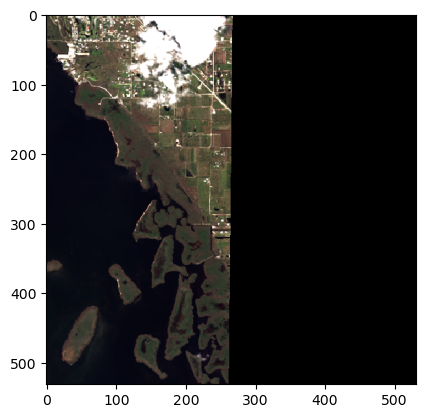

In [9]:
# normalise the RGB imagery for visualisation
RGB_array_norm = RGB_array.astype("float32")
RGB_array_norm -= np.percentile(RGB_array_norm, 2)
RGB_array_norm /= np.percentile(
    RGB_array_norm,
    97,  # you may need to play with this value to make sure everything is visible
)

RGB_array_norm = np.clip(RGB_array_norm, 0, 1)
plt.imshow(RGB_array_norm)

In [10]:
# create cloud and shadow mask with OCM
mask = predict_from_array(
    RGN_array,
    apply_no_data_mask=False,
)

Loading PM_model_2.2.10_RG_NIR_509_convnextv2_nano.fcmae_ft_in1k_PT.pth
Loading PM_model_2.2.10_RG_NIR_509_regnety_004.pycls_in1k_PT.pth


/home/nick/Documents/Work code/OmniCloudMask/omnicloudmask/cloud_mask.py:139: UserWarning: Significant no-data areas detected. Adjusting patch size to 265px and overlap to 132px to minimize no-data patches.
  warnings.warn(


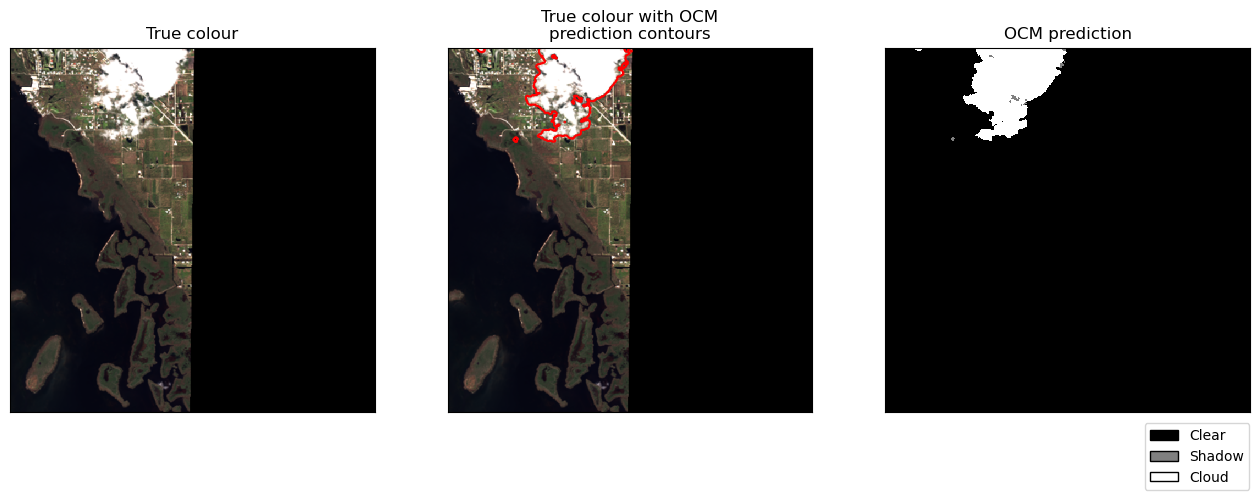

In [11]:
# display the results
custom_colors = ["black", "white", "white", "grey"]
cmap = ListedColormap(custom_colors)

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
ax[0].imshow(RGB_array_norm)
ax[1].imshow(RGB_array_norm)
ax[1].contour(mask[0] > 0, colors="red", linewidths=1.5)
ax[1].contour(mask[0] == 3, colors="red", linewidths=1.5)

ax[2].imshow(mask[0], vmin=0, vmax=3, cmap=cmap, interpolation="nearest")

legend_labels = ["Clear", "Shadow", "Cloud"]
legend_colors = ["black", "grey", "white"]

patches = [
    mpatches.Patch(
        facecolor=legend_colors[i], edgecolor="black", label=legend_labels[i]
    )
    for i in range(3)
]
fig.legend(handles=patches, loc="lower right", bbox_to_anchor=(0.904, 0.05))


for a in ax:
    a.set_xticks([])
    a.set_yticks([])

ax[0].set_title("True colour")
ax[1].set_title("True colour with OCM\nprediction contours")
ax[2].set_title("OCM prediction")

plt.show()